## Download/Load/Process Index

In [1]:
import urllib.request
import shutil
import os
import random

In [27]:
# Retrieve index and save to .txt file
url = "https://hiring.verkada.com/video/index.txt"

with urllib.request.urlopen(url) as response, open("./index.txt", "wb") as out_file:
    shutil.copyfileobj(response, out_file)

# Load index 
with open("./index.txt") as fp:
    index = fp.readlines()

index = sorted([int(x.strip().split(".")[0]) for x in index])  # Sorted in ascending order (Just to make sure)

# Need to process list of indices:
# 1. Have minute level granularity
# 2. Account for time skips w/ blanks

granular = []

granular.append(index[0]) 

granular_counter = 0 # Signal when to store timestamp

for i in range(1,len(index)):
    
    time_diff = index[i] - index[i-1] # How much time has passed between timestamps
    
    # Need to account for lost time if more than 2+ minutes have passed 
    if time_diff + granular_counter >= 120:
        # Complete the minute before the time-skip
        granular.append(-1)
        
        
        unaccounted = time_diff - (60 - granular_counter)
        
        # For each full min lost
        for i in range(0, int(unaccounted/60)):
            granular.append(-1)
        
        granular_counter = unaccounted % 60 # Reset counter w/ potential bias
        
    # If about a minute has passed (Isn't strictly 60 as sometimes indices diff by seconds not equal to 4)
    elif time_diff + granular_counter >= 60:
        granular.append(index[i])
        
        granular_counter = (time_diff + granular_counter) - 60 # Reset counter w/ potential bias
    
    # If less than a minute has passed
    else:
        granular_counter += time_diff

## Downloading files

Description:
Given a timestamp and an output directory, will download file from verkada server into directory. file_path should end in a "/".

In [3]:
def download(time_stamp, file_path):
    # Construct url/filename
    file_name = str(time_stamp) + ".ts"
    url = "https://hiring.verkada.com/video/" + file_name
    
    # urllib.request.urlopen -> Returns file-like object from HTTP response
    # shutil.copyfileobj -> Copy contents of file object to a "real" file
    
    with urllib.request.urlopen(url) as response, open(file_path+file_name, "wb") as out_file:
        shutil.copyfileobj(response, out_file)

In [4]:
# Testing
if not os.path.exists("./Test/"):
    os.makedirs("./Test/")
    
download(1538694088,"./Test/")

## Extract first frame

Description: Given a video file, will extract/return the first frame.



In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
def extract_frame1(file_path):
    cap = cv2.VideoCapture(file_path)
    
    cap.set(1, 0) # Not really needed - Video always reads first frame first but here for ref/clarity
    
    _, frame = cap.read()
    
    return frame

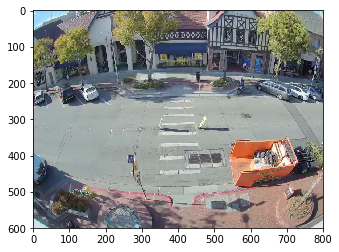

In [7]:
# Testing
frame = extract_frame1("./Test/1538694088.ts")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


plt.imshow(frame)
plt.show()

## Single Space Car identification

Prompt suggested using the Yolo3 system. Now, the strength of Yolo is the ability to recognize multiple objects with a single look (Verus, say, some sort of raster scan). However, optimizing for the goal of this particular assignment, we can crop a single square around the parking spot and only have to analyze the contents of that square. Hence, it may be unnecessary (And take more time) to use Yolo.

In [8]:
import numpy as np

In [9]:
# Hyperparam for model
conf_thresh = 0.5 
overlap_thresh = 0.3  

# Paths to model files
labels_path  = "./yolo-coco/coco.names"
weights_path = "./yolo-coco/yolov3.weights"
config_path  = "./yolo-coco/yolov3.cfg"

# Read model lables
with open(labels_path) as fp:
    labels = fp.readlines()

labels = [label.strip() for label in labels] # 'car', 'motorbike', & 'truck' are what we care about

# Load pre-trained model
nn = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Need names of output nodes for forward pass function
layer_names = nn.getLayerNames()
output_layer_names = [layer_names[i[0] - 1] for i in nn.getUnconnectedOutLayers()] 

Description: Given an image, will run yolo and return a cropped portion (The relevant parking spot) along with whether a vehicle has been detected.  

In [10]:
def yolov3(image):
    
    img_h, img_w = image.shape[:2]
    
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False) # Proeprocessing
    nn.setInput(blob) 
    
    layer_outputs = nn.forward(output_layer_names) # Run the neural-net
    
    boxes = [] # Windows corresponding to cars, motorbikes, or trucks
    conf = [] # Confidence corresponding to boxes 
    class_id = [] # Class id correpsonding to boxes
    
    # Filter out only window we want
    for output in layer_outputs:
        for obj in output:
            scores = obj[5:]
            obj_class_id = np.argmax(scores)
            obj_conf = float(scores[obj_class_id])
            
            if obj_conf > conf_thresh and labels[obj_class_id] in ['car', 'truck', 'motorbike']:
                # Yolo returns center of bounding box (x,y) and width and height
                # Need to scale to original image
                
                c_x,c_y, w, h = (obj[0:4] * np.array([img_w, img_h, img_w, img_h])).astype('int')
                
                x = int(c_x - (w/2))
                y = int(c_y - (h/2))
                
                boxes.append([x,y,int(w),int(h)])
                conf.append(obj_conf)
                class_id.append(labels[obj_class_id])
    
    # Get rid of weak/overlapping bounding boxes using non-maxima suppression
    idx = cv2.dnn.NMSBoxes(boxes, conf, conf_thresh, overlap_thresh)
    
    # Check for car in target region
    ovl_hyper = 0.4
    
    if len(idx) != 0:
        for i in idx.flatten():
            x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3] 
            
            #  x = 182, width = 94, y = 205, height = 61
            start_x = max(x,182)
            start_y = max(y,205)
            o_w = min(x+w, 182+94) - start_x
            o_h = min(y+h, 205+61) - start_y

            if o_w < 0 or o_h < 0:
                ovl = 0.0
            else:
                ovl = (o_w*o_h) / (61*94)
            
            if ovl > ovl_hyper:
                #cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
                return True, image[205:205+61, 182:182+94]
            
    return False, image[205:205+61, 182:182+94]



True
True


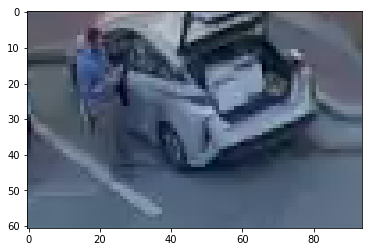

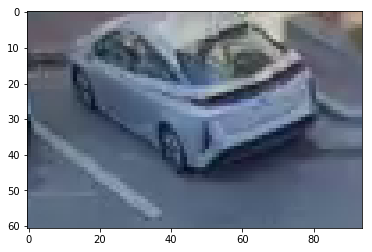

In [11]:
# Testing
download(1538076303,"./Test/")
download(1538076735,"./Test/")

frame1 = extract_frame1("./Test/1538076303.ts") # Has human in it
frame2 = extract_frame1("./Test/1538076735.ts") 

truth1, cropped1 = yolov3(frame1)
truth2, cropped2 = yolov3(frame2)

# Should both be true
print(truth1) 
print(truth2)

plt.imshow(cv2.cvtColor(cropped1, cv2.COLOR_BGR2RGB))
plt.show()
 
plt.imshow(cv2.cvtColor(cropped2, cv2.COLOR_BGR2RGB))
plt.show()

## Similarity between 2 cars

Plan was originally to use feature matching using the ORB descriptor to tell if 2 cars were identical. However, there were many false-positive feature matches using this method. One reason could be because of the texture(Or lack there of) of these images.

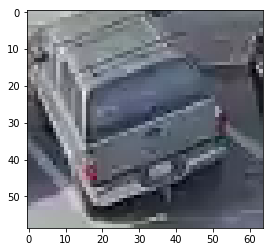

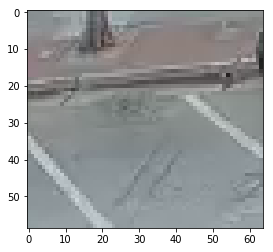

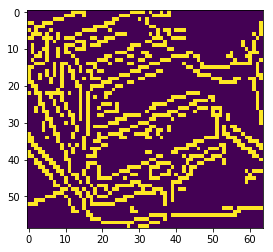

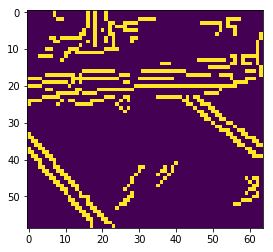

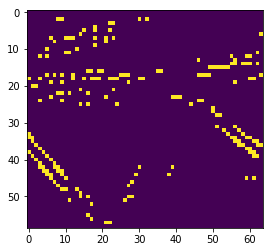

In [31]:
# Experimenting

# For reference (Same car, different lighting)
# 1538694088
# 1538694412

# For reference (Different car, different lighting)
# 1538189686
# 1538801568

#ts_1 = 1538694088
#ts_2 = 1538694412

ts_1 =random.choice(index)
ts_2 =random.choice(index)

download(ts_1,"./Test/")
download(ts_2,"./Test/")


img1 = extract_frame1("./Test/"+str(ts_1)+".ts")[202:261,125:189,:]
img2 = extract_frame1("./Test/"+str(ts_2)+".ts")[202:261,125:189,:]


img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


canny = cv2.Canny(img1_gray, 80, 120)
canny2 = cv2.Canny(img2_gray, 80, 120)

plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(canny)
plt.show()

plt.imshow(canny2)
plt.show()

plt.imshow(canny&canny2)
plt.show()

In [29]:
# Further experimentation

img3 = canny&canny2
_, contours, _ = cv2.findContours(img3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

matches = 0
summed = 0

for c in contours:
    if cv2.arcLength(c,False) >= 6.0:
        summed += cv2.arcLength(c,False)
        matches += 1

print(summed)
print(matches)
print(len(contours))

18.071067690849304
2
129


Using contours and judging the arclength of their overlap seems to work well w/ preliminary testing. Another thought along the same line, is running a cnn (or other classification program) on this contour and seeing if a car is still detected.


For now, criteria is whether summed arch length of contours > 6, is greater than 400.

Description: Given 2 images of cars, will return True if similar and False if not similar.

In [14]:
# Returns boolean
def compare(img1,img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    canny = cv2.Canny(img1_gray, 80, 120)
    canny2 = cv2.Canny(img2_gray, 80, 120)
    
    img3 = canny&canny2
    _, contours, _ = cv2.findContours(img3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    matches = 0
    summed = 0
    for c in contours:
        if cv2.arcLength(c,False) >= 6.0:
            summed += cv2.arcLength(c,False)
            matches += 1
    
    if summed >= 400:
        return True
    else:
        return False

# Returns integer
def compare2(img1,img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    canny = cv2.Canny(img1_gray, 80, 120)
    canny2 = cv2.Canny(img2_gray, 80, 120)
    
    img3 = canny&canny2
    _, contours, _ = cv2.findContours(img3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    matches = 0
    summed = 0
    for c in contours:
        if cv2.arcLength(c,False) >= 6.0:
            summed += cv2.arcLength(c,False)
            matches += 1
    
    return summed

## Idenfity Car Color

In [15]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

1539005806


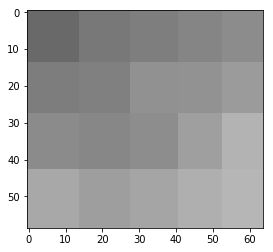

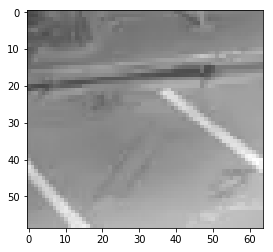

In [16]:
# Experimentation

# Use superpixels to simplify data

r = random.choice(index)

download(r,"./Test/")
img = extract_frame1("./Test/"+str(r)+".ts")[202:261,125:189,:]

orig = np.copy(img)

'''
n_segments  - Number of superpixels
compactness - Balances color prox and space prox (Higher values give more weight space prox) 
            - Log scale (0.01, 0.1, 10, 100)
            - Increase value leads to more "square-like" superpixels
max_iter    - For k-means
sigma       - Width of Gaussian smoothing kernel

convert2lab - Highly recommended
enforce_connectivity 
'''

segments = slic(img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), n_segments=20, compactness=100, sigma=3)

# Average color within segment
for s in np.unique(segments):
    mask = (segments == s)
    
    avg = np.mean(img[mask],axis=0)
    
    img[mask] = avg


print(r)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.show()

Seems like superpixels clean this data quite nicely. Should have an easier time working with the image now.

Description: Given an image with a car, will idenfiy/return color of the car.

In [19]:
def findColor(orig):
    img = np.copy(orig)
    
    segments = slic(img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), n_segments=20, compactness=100, sigma=3)
    
    avg_list = []
    # Average color within segment
    for s in np.unique(segments):
        mask = (segments == s)
        
        avg = np.mean(img[mask],axis=0)
        
        img[mask] = avg
            
        avg_list.append(avg)
        
    avg_list = np.array(avg_list)

    # Can assume non-trivial area because of how segmentation is done
    # Hence, a small artifact shouldn't be a problem because of avging
    
    # Blue  - Ratio of blue is sig higher for 1 region
    # Green - Ratio of green is sig higher for 1 region 
    # Red   - Ratio of red is sig higher for 1 region
    
    simple = ["blue", "green", "red"]
    
    for i in range(len(simple)):
        j = [0,1,2]
        j.remove(i)
        
        # https://en.wikipedia.org/wiki/Color_difference
        # An attempt on how color is perceived
        # Most likely how color contributes to brightness of colors (Which is sorta what we are trying to measure)
        
        c = [0.11,0.59,0.3]
        c1 = c.pop(i)

        ratios = c1*avg_list[:,i]/(c[0]*avg_list[:,j[0]] + c[1]*avg_list[:,j[1]])
        
        med = np.median(ratios)
        
        mad = np.median(np.abs(ratios - med))
        
        mod_z = 0.6745*(ratios-med)/(mad + 1e-10)
        
        if np.max(mod_z) > 3.5:
            return simple[i]

    
    # To distinguish between Black, White, & Gray
    # Can observe gradient in "value" of HSV 
    # "value" is indicitive of brightness
    # Black - Should lower the value 
    # White - Should increase the value
    # Grey  - Value should remain about same
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Convert to HSV
    value = img[:,:,2] # Only need value slice
    h,w = value.shape
    
    boxy = np.zeros((h,w))
    
    boxy[int(0.25*h):int(0.75*h),int(0.25*w):int(0.75*w)] = value[int(0.25*h):int(0.75*h),int(0.25*w):int(0.75*w)]

    center = value[int(0.25*h):int(0.75*h),int(0.25*w):int(0.75*w)]
    
    center_h, center_w = center.shape
    
    weight = (h*w - center_h*center_w)/(center_h*center_w)
    
    vc = np.sum(center)
    vb = np.sum(value-boxy)
    
    ratio = weight*vc/vb 
    
    if ratio < 0.9:
        return "black"
    
    elif ratio > 1.1:
        return "white"
    
    return "grey"

1539024713
red


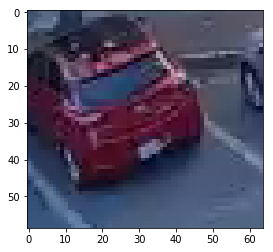

In [21]:
# Testing

# Testing data
# Red - 1539024713, 1539031511
# Blue - 1538093734, 1539196332
# Black - 1538351989, 1538101260 (One of these might be really dark blue actually..)
# Grey - 1539206652, 1538176948, 1538616300
# White - 1538508364, 1538537143

r = random.choice([1539024713, 1539031511, 1538093734, 1539196332, 1538351989, 1538101260, 
                   1539206652, 1538176948, 1538616300, 1538508364, 1538537143])

#r = random.choice(index)
download(r,"./Test/")

img = extract_frame1("./Test/"+str(r)+".ts")[202:261,125:189,:]

print(r)
print(findColor(img))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

The downsides of this method are the potential for very incorrect results given noise and the somewhat arbitrary choice for "hyperparameters" (At least for choosing between white, grey, and black).

A more involved approach could be making a UNet to segment out cars and then using a dense neural-network to choose the appropriate color.

## Monitoring / All Together

Description: Given a start timestamp and end timestamp wil monitor the parking spot w/ granularity of 1 minute and print when cars arive and depart.

In [24]:
# Assume valid start time and end time
# Each file is 4 seconds apart & Output shown to be accurate to minute (15 vids)
    
def analyze(start_time, end_time):
    
    if not os.path.exists("./Monitor/"):
        os.makedirs("./Monitor/")
    
    if not os.path.exists("./Proof/"):
        os.makedirs("./Proof/")
        
    car_tracked = False # Flag for car currently being tracked
    
    o_pos = None # Position car was first seen (For purpose of measuring time)
    
    c_pos = int((start_time - granular[0])/60) # Current position
    
    saved_img = None # Saved image of car
    saved_init = None # saved_img is updated periodically, this is the original image 
    saved_counter = 0 # Update saved image of car
        
    end_pos = int((end_time - granular[0])/60) # Last footage to be observed
    
    time_skip_start = -1 # Counter for time skips (Minutes without footage)

    while c_pos <= end_pos:
        
        if granular[c_pos] != -1:
            download(granular[c_pos], "./Monitor/")   # Download next frame seq
            frame = extract_frame1("./Monitor/"+str(granular[c_pos])+".ts")  # Take out first frame 
            car_identified, cropped = yolov3(frame) # Identify if a car is present
            
            # Car is being tracked 
            if car_tracked == True and not ((not car_identified and compare2(cropped,saved_img) > 500) or (car_identified and compare(cropped, saved_img))):
                
                # Approx times for when car came and left
                s_time = granular[o_pos]
                e_time = granular[c_pos]
                    
                if time_skip_start != -1: # Car changed from before time-skip
                    print("Time skip: Car left between {} and {}".format(time_skip_start, c_pos))
                        
                else:
                    dur = c_pos - o_pos # Minutes car was in spot
                    print("Parked until: {} ({} minutes)".format(e_time, dur))
                
                out_start = "{}_{}_1.jpg".format(s_time, e_time)
                out_end   = "{}_{}_2.jpg".format(s_time, e_time)
                
                cv2.imwrite("./Proof/" + out_start, saved_init)
                cv2.imwrite("./Proof/" + out_end, cropped)
                
                print("Proof saved as {} and {} to ./Proof directory\n".format(out_start, out_end))
                
                car_tracked = False
        
            # Car is being tracked and current frame contains the same car
            # Questionable choice
            elif car_tracked == True and car_identified and compare(cropped, saved_img):
                saved_counter += 1 
            
                if saved_counter % 5 == 0: # Update the saved car img every 5 minutes (Noise adds up over time)
                    saved_img = np.copy(cropped)
                    cv2.imwrite("./hmm/"+str(saved_counter)+".jpg",saved_img)
        
            # Car isn't being tracked
            if car_tracked == False and car_identified:
                color = findColor(cropped)
                print("Found {} car at: {}".format(color,granular[c_pos]))
            
                saved_img = np.copy(cropped)
                saved_init = np.copy(cropped)
                o_pos = c_pos
                car_tracked = True
            
            time_skip_start = -1 # Reset time_skip var (Even if car didn't change) 
            
        else:
            time_skip_start = c_pos - 1
    
        c_pos += 1
   

In [25]:
analyze(1538076003,1538106185) 

Found grey car at: 1538076183
Parked until: 1538077926 (29 minutes)
Proof saved as 1538076183_1538077926_1.jpg and 1538076183_1538077926_2.jpg to ./Proof directory

Found blue car at: 1538077986
Parked until: 1538078226 (4 minutes)
Proof saved as 1538077986_1538078226_1.jpg and 1538077986_1538078226_2.jpg to ./Proof directory

Found black car at: 1538079366
Parked until: 1538082185 (47 minutes)
Proof saved as 1538079366_1538082185_1.jpg and 1538079366_1538082185_2.jpg to ./Proof directory

Found blue car at: 1538083025
Parked until: 1538083445 (7 minutes)
Proof saved as 1538083025_1538083445_1.jpg and 1538083025_1538083445_2.jpg to ./Proof directory

Found black car at: 1538084824
Parked until: 1538097185 (206 minutes)
Proof saved as 1538084824_1538097185_1.jpg and 1538084824_1538097185_2.jpg to ./Proof directory

Found black car at: 1538097485
Parked until: 1538098624 (19 minutes)
Proof saved as 1538097485_1538098624_1.jpg and 1538097485_1538098624_2.jpg to ./Proof directory

Found bl

For extension to multiple parking slots, I'd run yolo on the full frame and preserve the entire frame versus the small window I currently preserve. I'd repeat this using 5k random sets(2 images within a span of 10 minutes). Locations where cars are consistently detected will be marked as parking slots and their locations stored in an array.